In [ ]:
!pip install -q transformers datasets peft accelerate bitsandbytes scipy torch trl
!pip install -q tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
from datasets import Dataset, concatenate_datasets
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
import warnings
warnings.filterwarnings('ignore')
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer
logging.set_verbosity_info()
print(f"GPU available: {torch.cuda.is_available()}")
print(f"CUDA device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

GPU available: True
CUDA device: Tesla T4


In [ ]:
MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"
OUTPUT_DIR = "/content/drive/MyDrive/Thesis/finetune_qwen/output_qwen"
LORA_ALPHA = 16
LORA_DROPOUT = 0.1
LORA_R = 8

DATASET_PATHS = [
    "/content/dataset2.csv"
]

In [ ]:
def prepare_dataset(dataset_path):
    try:
        df = pd.read_csv(dataset_path)
        print(f"Dataset loaded from {dataset_path} with shape: {df.shape}")
        print(df.head())

        # Extract only Question and Answer columns
        if all(col in df.columns for col in ['Question', 'Answer']):
            df_filtered = df[['Question', 'Answer']]
        elif all(col in df.columns for col in ['question', 'answer']):
            df_filtered = df[['question', 'answer']]
            # Rename columns for consistency
            df_filtered = df_filtered.rename(columns={"question": "Question", "answer": "Answer"})
        else:
            raise ValueError(f"Dataset {dataset_path} doesn't have the required Question/Answer columns")

        # Create the dataset
        dataset_dict = {
            "question": df_filtered["Question"].tolist(),
            "answer": df_filtered["Answer"].tolist()
        }
        return Dataset.from_dict(dataset_dict)
    except Exception as e:
        print(f"Error loading dataset from {dataset_path}: {e}")
        return None

In [ ]:
datasets = []
for path in DATASET_PATHS:
    dataset = prepare_dataset(path)
    if dataset is not None:
        datasets.append(dataset)
        print(f"Successfully loaded dataset from {path} with {len(dataset)} examples")

if not datasets:
    raise ValueError("No valid datasets were loaded. Please check your dataset paths and formats.")

# Combine all datasets into one
if len(datasets) > 1:
    combined_dataset = concatenate_datasets(datasets)
    print(f"Combined dataset created with {len(combined_dataset)} examples")
else:
    combined_dataset = datasets[0]
    print(f"Single dataset used with {len(combined_dataset)} examples")

# Optional: Shuffle the combined dataset
combined_dataset = combined_dataset.shuffle(seed=42)

Dataset loaded from /content/dataset2.csv with shape: (15080, 4)
                                               input  \
0  I don't know how to cope with depression and f...   
1  I'm overwhelmed by constant worry and feeling ...   
2  I'm having trouble feeling hopeless and feelin...   
3  I'm having trouble anxiety and feeling unfocused.   
4  I'm feeling feeling hopeless and feeling reall...   

                                              output  \
0  That sounds like a lot to handle. How are you ...   
1  You are good enough just as you are. If you'd ...   
2  Burnout is really tough, and it’s important to...   
3  That sounds like a lot to handle. How are you ...   
4  Staying motivated can be tough when you’re fee...   

                                            Question  \
0  Tôi không biết làm thế nào để đối phó với chứn...   
1  Tôi bị choáng ngợp bởi sự lo lắng thường xuyên...   
2  Tôi khó có cảm giác tuyệt vọng và cảm thấy căn...   
3  Tôi đang gặp rắc rối với sự lo lắn

In [ ]:
for i in range(5):
    print(f"--- Example {i+1} ---")
    print("Question:", combined_dataset[i]['question'])
    print("Answer:", combined_dataset[i]['answer'])
    print()


--- Example 1 ---
Question: Tôi cảm thấy lo lắng thường xuyên và cảm thấy mất tập trung.
Answer: Tôi thực sự rất tiếc khi nghe điều đó. Đôi khi cảm thấy lo lắng cũng không sao. Bạn có muốn nói thêm về nó?

--- Example 2 ---
Question: Tôi cảm thấy lo lắng và cảm thấy thực sự căng thẳng.
Answer: Tôi hiểu điều đó có thể mệt mỏi đến mức nào. Bạn có muốn khám phá những cách để thư giãn hoặc nạp lại năng lượng?

--- Example 3 ---
Question: Mức độ căng thẳng của tôi đã tăng vọt và tôi hy vọng việc tư vấn có thể hướng dẫn tôi tìm kiếm sự cân bằng lành mạnh hơn. Tôi cảm thấy áp lực to lớn từ công việc, trách nhiệm gia đình và việc duy trì các mối quan hệ của mình. Hầu hết các ngày, tôi đều bị đau đầu do căng thẳng và tôi nghiến chặt hàm đến mức gây đau. Tháng trước, tôi đã cáu kỉnh với đối tác của mình trong một cuộc tranh cãi không giống tôi chút nào. Tôi không muốn căng thẳng tiếp tục ảnh hưởng đến sức khỏe của tôi và những người xung quanh.
Answer: Chắc chắn có thể tìm được sự cân bằng lành 

In [ ]:
from getpass import getpass
from huggingface_hub import login
hf_token = getpass("Nhập Hugging Face token của bạn: ")
login(hf_token)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Configure quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

# Load the model with quantization
print("Loading model. This may take a few minutes...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# Prepare the model for training
model = prepare_model_for_kbit_training(model)

# Define LoRA configuration
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
)
model = get_peft_model(model, lora_config)
print(f"Trainable parameters: {model.print_trainable_parameters()}")

Nhập Hugging Face token của bạn: ··········


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-3B-Instruct/snapshots/aa8e72537993ba99e69dfaafa59ed015b17504d1/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-3B-Instruct/snapshots/aa8e72537993ba99e69dfaafa59ed015b17504d1/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-3B-Instruct/snapshots/aa8e72537993ba99e69dfaafa59ed015b17504d1/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-3B-Instruct/snapshots/aa8e72537993ba99e69dfaafa59ed015b17504d1/tokenizer_config.json
loading file chat_template.jinja from cache at None
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading model. This may take a few minutes...


config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-3B-Instruct/snapshots/aa8e72537993ba99e69dfaafa59ed015b17504d1/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 32768,
  "max_window_layers": 70,
  "model_type": "qwen2",
  "num_attention_heads": 16,
  "num_hidden_layers": 36,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.51.3",
  "use_cache": true,
  "use_sliding_window": false,
  "vocab_size": 151936
}

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable m

model.safetensors.index.json:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-3B-Instruct/snapshots/aa8e72537993ba99e69dfaafa59ed015b17504d1/model.safetensors.index.json


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Instantiating Qwen2ForCausalLM model under default dtype torch.float16.
Generate config GenerationConfig {
  "bos_token_id": 151643,
  "eos_token_id": 151645
}

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
target_dtype {target_dtype} is replaced by `CustomDtype.INT4` for 4-bit BnB quantization


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing Qwen2ForCausalLM.

All the weights of Qwen2ForCausalLM were initialized from the model checkpoint at Qwen/Qwen2.5-3B-Instruct.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Qwen2ForCausalLM for predictions without further training.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-3B-Instruct/snapshots/aa8e72537993ba99e69dfaafa59ed015b17504d1/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 151643,
  "do_sample": true,
  "eos_token_id": [
    151645,
    151643
  ],
  "pad_token_id": 151643,
  "repetition_penalty": 1.05,
  "temperature": 0.7,
  "top_k": 20,
  "top_p": 0.8
}



trainable params: 14,966,784 || all params: 3,100,905,472 || trainable%: 0.4827
Trainable parameters: None


In [ ]:
def formatting_prompts_func(example):
    q = example["question"]
    a = example["answer"]

    # Prompt chung thêm vào đầu câu trả lời
    system_prompt = "Bạn là chatbot AI tư vấn về sức khỏe tinh thần cho bệnh nhân, hãy đưa ra câu trả lời một cách ân cần, gần gũi và đồng cảm với bệnh nhân. Khi kết thúc câu trả lời hãy cho bệnh nhân những lời khuyên chân thành nhất."

    # Combine prompt chung với câu hỏi và câu trả lời
    return {"text": f"{system_prompt}\n\nQuestion: {q}\nAnswer: {a}"}

combined_dataset = combined_dataset.map(formatting_prompts_func)
print(combined_dataset[0])

Map:   0%|          | 0/15080 [00:00<?, ? examples/s]

{'question': 'Tôi cảm thấy lòng tự trọng bị hạ thấp và cảm thấy lạc lõng.', 'answer': 'Nghe có vẻ có rất nhiều việc phải xử lý. Bạn đối mặt với mọi chuyện xảy ra trong cuộc sống như thế nào?', 'text': 'Bạn là chatbot AI tư vấn về sức khỏe tinh thần cho bệnh nhân, hãy đưa ra câu trả lời một cách ân cần, gần gũi và đồng cảm với bệnh nhân. Khi kết thúc câu trả lời hãy cho bệnh nhân những lời khuyên chân thành nhất.\n\nQuestion: Tôi cảm thấy lòng tự trọng bị hạ thấp và cảm thấy lạc lõng.\nAnswer: Nghe có vẻ có rất nhiều việc phải xử lý. Bạn đối mặt với mọi chuyện xảy ra trong cuộc sống như thế nào?'}


In [ ]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    max_steps=1000,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    save_steps=200,
    logging_steps=10,
    learning_rate=2e-4,
    weight_decay=0.01,
    fp16=True,
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    report_to="none",
)

# Create SFT trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=combined_dataset,
)

# Train the model
print("Starting training...")
trainer.train()

# Save the trained model
print("Saving model...")
trainer.save_model()

PyTorch: setting up devices
PyTorch: setting up devices
loading file vocab.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-3B-Instruct/snapshots/aa8e72537993ba99e69dfaafa59ed015b17504d1/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-3B-Instruct/snapshots/aa8e72537993ba99e69dfaafa59ed015b17504d1/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-3B-Instruct/snapshots/aa8e72537993ba99e69dfaafa59ed015b17504d1/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-3B-Instruct/snapshots/aa8e72537993ba99e69dfaafa59ed015b17504d1/tokenizer_config.json
loading file chat_template.jinja from cache at None
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tune

Converting train dataset to ChatML:   0%|          | 0/15080 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/15080 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/15080 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/15080 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
Using auto half precision backend
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting training...


The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text, question, answer. If text, question, answer are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 15,080
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 8
  Total optimization steps = 1,000
  Number of trainable parameters = 14,966,784
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,2.540200
20,2.018300
30,1.134900
40,0.613000
50,0.379000
60,0.214700
70,0.169000
80,0.220800
90,0.157700
100,0.142100


Saving model checkpoint to /content/drive/MyDrive/Thesis/finetune_qwen/output_qwen/checkpoint-200
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-3B-Instruct/snapshots/aa8e72537993ba99e69dfaafa59ed015b17504d1/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 32768,
  "max_window_layers": 70,
  "model_type": "qwen2",
  "num_attention_heads": 16,
  "num_hidden_layers": 36,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.51.3",
  "use_cache": true,
  "use_sliding_window": false,
  "vocab_size": 151936
}

tokenizer co

Saving model...


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-3B-Instruct/snapshots/aa8e72537993ba99e69dfaafa59ed015b17504d1/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 32768,
  "max_window_layers": 70,
  "model_type": "qwen2",
  "num_attention_heads": 16,
  "num_hidden_layers": 36,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.51.3",
  "use_cache": true,
  "use_sliding_window": false,
  "vocab_size": 151936
}

tokenizer config file saved in /content/drive/MyDrive/Thesis/finetune_qwen/output_qwen/tokenizer_config.json
S

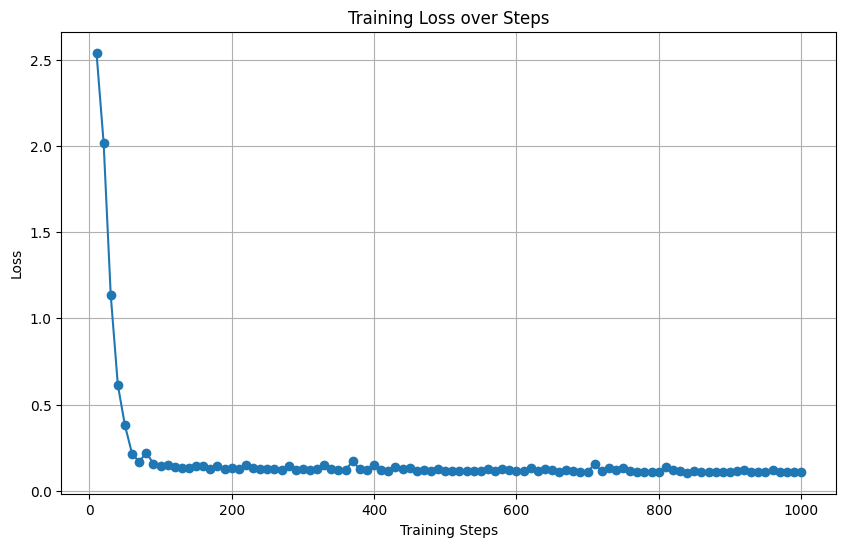

In [ ]:
import matplotlib.pyplot as plt

# Lấy log history từ trainer
logs = trainer.state.log_history

# Trích xuất loss và step từ log
steps = []
losses = []

for log in logs:
    if "loss" in log and "step" in log:
        steps.append(log["step"])
        losses.append(log["loss"])

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, marker='o')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.grid(True)
plt.show()

In [ ]:
from transformers import BitsAndBytesConfig
import torch

def save_merged_model(model_path, save_path):
    print(f"Creating merged model at {save_path}...")

    # Cấu hình quantization 4-bit
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,              # Kích hoạt quantization 4-bit
        bnb_4bit_quant_type="nf4",      # Loại quantization (nf4 hoặc fp4)
        bnb_4bit_use_double_quant=True, # Sử dụng double quantization để tiết kiệm thêm bộ nhớ
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    # Load base model với quantization 4-bit
    base_model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=bnb_config,  # Áp dụng cấu hình 4-bit
        device_map="auto",
        trust_remote_code=True
    )

    # Load LoRA adapter
    model = PeftModel.from_pretrained(base_model, model_path)

    # Merge LoRA vào base model
    merged_model = model.merge_and_unload()

    # Lưu model đã merged
    merged_model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

    print(f"Merged model saved to {save_path}")

# Gọi hàm để lưu model
save_merged_model(OUTPUT_DIR, "/content/drive/MyDrive/Thesis/finetune_qwen/qwen_finetune")
print("Process completed successfully!")

Creating merged model at /content/drive/MyDrive/Thesis/finetune_qwen/qwen_finetune...


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-3B-Instruct/snapshots/aa8e72537993ba99e69dfaafa59ed015b17504d1/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 32768,
  "max_window_layers": 70,
  "model_type": "qwen2",
  "num_attention_heads": 16,
  "num_hidden_layers": 36,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.51.3",
  "use_cache": true,
  "use_sliding_window": false,
  "vocab_size": 151936
}

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable m

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing Qwen2ForCausalLM.

All the weights of Qwen2ForCausalLM were initialized from the model checkpoint at Qwen/Qwen2.5-3B-Instruct.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Qwen2ForCausalLM for predictions without further training.
loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-3B-Instruct/snapshots/aa8e72537993ba99e69dfaafa59ed015b17504d1/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 151643,
  "do_sample": true,
  "eos_token_id": [
    151645,
    151643
  ],
  "pad_token_id": 151643,
  "repetition_penalty": 1.05,
  "temperature": 0.7,
  "top_k": 20,
  "top_p": 0.8
}

Configuration saved in /content/drive/MyDrive/Thesis/finetune_qwen/qwen_finetune/config.json
Configuration saved in /content/drive/MyDrive/Thesis/finetune_qwen/qwen_finetune/generation_config.json
Model weights save

Merged model saved to /content/drive/MyDrive/Thesis/finetune_qwen/qwen_finetune
Process completed successfully!


In [ ]:
!zip -r /content/drive/MyDrive/Thesis/finetune_qwen/qwen-finetune.zip /content/drive/MyDrive/Thesis/finetune_qwen/qwen-finetune

	zip warning: name not matched: /content/drive/MyDrive/Thesis/finetune_qwen/qwen-finetune

zip error: Nothing to do! (try: zip -r /content/drive/MyDrive/Thesis/finetune_qwen/qwen-finetune.zip . -i /content/drive/MyDrive/Thesis/finetune_qwen/qwen-finetune)


In [ ]:
!pip install transformers torch evaluate datasets rouge-score nltk
!pip install -U bitsandbytes

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.1 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6df5f0bab3ce51a098efaab24a10aaf8c533d9e547e2a4243230f3a9ffa3bb37
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
# 1. Kết nối Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Cài đặt và tải dữ liệu NLTK (cần cho METEOR và một số biến thể ROUGE/BLEU)
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# 3. Cài đặt thư viện cần thiết (nếu chưa cài đặt trong phiên làm việc)
# Bạn có thể bỏ qua bước này nếu đã chạy ở trên hoặc trong một ô code khác
# !pip install transformers torch evaluate datasets rouge-score pandas

# 4. Tải Model và Tokenizer (sử dụng đường dẫn và loại model của bạn)
from transformers import AutoModelForCausalLM, AutoTokenizer # **Sửa thành AutoModelForCausalLM**

model_path = '/content/drive/MyDrive/Thesis/finetune_qwen/qwen_finetune' # Đường dẫn đến model của bạn

# Qwen có thể cần trust_remote_code=True tùy phiên bản
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True) # **Sửa thành AutoModelForCausalLM**

# (Tùy chọn) Đẩy model lên GPU nếu có để inference nhanh hơn
import torch
if torch.cuda.is_available():
    model.to('cuda')
    print("Model đã được chuyển lên GPU")
else:
    print("Không tìm thấy GPU, chạy trên CPU")

# 5. Chuẩn bị Dữ liệu Test và Chạy Inference

# Khởi tạo danh sách lưu output ĐẶT BÊN NGOÀI khối try
generated_outputs = []

import pandas as pd
import evaluate

# Đường dẫn đến file dataset test của bạn trên Drive
test_data_path = '/content/dataset1.csv' # **Thay thế bằng đường dẫn thực tế của bạn**

try:
    df_test = pd.read_csv(test_data_path)
    # Lấy cột 'question' làm input và 'answer' làm reference
    inputs = df_test['Question'].tolist()
    references_list = df_test['Answer'].tolist()

    # Chuẩn bị danh sách references ở định dạng List[List[str]] cho thư viện evaluate
    references_for_metrics = [[ans] for ans in references_list]

    print(f"Đang chạy inference cho {len(inputs)} ví dụ...")

    # Vòng lặp chạy inference cho từng input
    for i, input_text in enumerate(inputs):
        # Qwen thường dùng định dạng chat. Chuẩn bị prompt theo định dạng chat của Qwen
        # Nếu model của bạn được finetune trên định dạng khác, bạn cần điều chỉnh phần này
        messages = [
            {"role": "user", "content": input_text}
        ]
        # apply_chat_template sẽ chuyển messages thành chuỗi input token ID theo định dạng mà Qwen hiểu
        # add_generation_prompt=True thêm các token đặc biệt báo hiệu model bắt đầu sinh response
        input_ids = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt"
        )

        # (Tùy chọn) Đẩy input lên GPU
        if torch.cuda.is_available():
            input_ids = input_ids.to('cuda')

        # Chạy generate
        # max_new_tokens: Số lượng token tối đa model được phép sinh ra sau prompt
        # Các tham số khác (num_beams, do_sample, top_k, top_p...) có thể cần tinh chỉnh
        output_ids = model.generate(
            input_ids,
            max_new_tokens=1024, # Giới hạn độ dài output
            do_sample=False,     # Sử dụng greedy search (hoặc True để lấy mẫu)
            # num_beams=1,       # Bỏ comment nếu muốn dùng Beam search
            pad_token_id=tokenizer.eos_token_id # Qwen dùng EOS làm pad token
        )

        # Decode output.
        # Cần bỏ qua input_ids ban đầu khi decode output_ids vì Causal LM sinh tiếp từ input
        # Decode từ vị trí input_ids.shape[-1] trở đi
        decoded_output = tokenizer.decode(
            output_ids[0][input_ids.shape[-1]:], # Cắt bỏ phần input prompt
            skip_special_tokens=True
        )
        generated_outputs.append(decoded_output) # Thêm output vào danh sách

        if (i + 1) % 10 == 0:
            print(f"Đã xử lý {i+1}/{len(inputs)} ví dụ.")

except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file dataset tại đường dẫn: {test_data_path}")
    print("Hãy đảm bảo đường dẫn và tên file chính xác.")
except KeyError as e:
    print(f"Lỗi: Thiếu cột trong file dataset. Đảm bảo có cột '{e}'")
except Exception as e:
    print(f"Đã xảy ra lỗi trong quá trình xử lý inference: {e}")


# 6. Tính toán Metric (Chỉ chạy nếu quá trình inference thành công và có output được tạo ra)
# Kiểm tra xem generated_outputs có phần tử nào không
if generated_outputs:
    print("\nBắt đầu tính toán metrics...")

    # Tính BLEU
    try:
        bleu = evaluate.load("bleu")
        # BLEU cần references là List[List[str]]
        bleu_results = bleu.compute(predictions=generated_outputs, references=references_for_metrics)
        print(f"\n--- Kết quả BLEU ---")
        print(f"BLEU score: {bleu_results['bleu']:.4f}") # In 4 chữ số thập phân
    except Exception as e:
        print(f"Lỗi khi tính BLEU: {e}")


    # Tính ROUGE
    try:
        rouge = evaluate.load("rouge")
        # ROUGE có thể nhận references là List[str] hoặc List[List[str]]
        rouge_results = rouge.compute(predictions=generated_outputs, references=references_for_metrics)
        print(f"\n--- Kết quả ROUGE ---")
        for key, value in rouge_results.items():
            print(f"- {key}: {value:.4f}") # In 4 chữ số thập phân
    except Exception as e:
        print(f"Lỗi khi tính ROUGE: {e}")


    # Tính METEOR
    try:
        meteor = evaluate.load("meteor")
        # METEOR cần references là List[List[str]]
        meteor_results = meteor.compute(predictions=generated_outputs, references=references_for_metrics)
        print(f"\n--- Kết quả METEOR ---")
        print(f"METEOR score: {meteor_results['meteor']:.4f}") # In 4 chữ số thập phân
    except Exception as e:
         print(f"Lỗi khi tính METEOR: {e}")

else:
    # Message này chỉ hiển thị nếu generated_outputs RỖNG (ví dụ do lỗi xảy ra ngay từ đầu trong try block)
    print("\nKhông có output được tạo ra, không thể tính metrics.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
loading file vocab.json
loading file merges.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file chat_template.jinja


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
loading configuration file /content/drive/MyDrive/Thesis/finetune_qwen/qwen_finetune/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 32768,
  "max_window_layers": 70,
  "model_type": "qwen2",
  "num_attention_heads": 16,
  "num_hidden_layers": 36,
  "num_key_value_heads": 2,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": 

Model đã được chuyển lên GPU
Đang chạy inference cho 116 ví dụ...
Đã xử lý 10/116 ví dụ.
Đã xử lý 20/116 ví dụ.
Đã xử lý 30/116 ví dụ.
Đã xử lý 40/116 ví dụ.
Đã xử lý 50/116 ví dụ.
Đã xử lý 60/116 ví dụ.
Đã xử lý 70/116 ví dụ.
